In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from sys import argv
import ROOT
from ROOT import TH2F, TCanvas, TFile
import pandas as pd
from dataclasses import make_dataclass
import multiprocessing as mp

Welcome to JupyROOT 6.22/08


## Part 1, read log and get fit parameters and fit fraction

### Part 1-1, read log
Every bootstrapping sample do 10 random fits.\
Use func `read_logscan` to read the output of these fit results.\
Then use `pd.groupby` and `pd.merge` to get min NLL and its result index for each bootstrapping. \

In [2]:
def read_logscan(logfile):
    """This function is used to read logfiles generated by qnFit/sort.sh.
    To read the nll, file id and fit status into a dataframe.

    Args:
        logfile (_type_): _description_

    Returns:
        dataframe: _description_
    """
    # mass: bootstrapping file; id: fit result index; nll: NLL; status;
    one_log = make_dataclass("one_log", [("mass", float), ("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        mass_temp = l1.split()[0].split("//")[1].split("-")[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[2].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(float(mass_temp), str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [3]:
# Use pd.groupby and pd.merge to get the id of minimum nll for each bootstrapping sample.
df1 = read_logscan("/disk401/lhcb/qinning/b2dpp_farm10/qnFit/bootstrapping/check_logBootstrappSpline.txt")
df_converged = df1[df1["status"] == "CONVERGED"]
df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
print(df_merge.head())
print(df_merge.shape)

   mass    id      nll     status
0   0.0  7002 -11140.3  CONVERGED
1   1.0  7018 -11394.1  CONVERGED
2   2.0  7022 -11202.5  CONVERGED
3   3.0  7035 -11251.8  CONVERGED
4   4.0  7041 -10959.0  CONVERGED
(200, 4)


### Part 1-2, get fit parameters
The `df_merge` could give us the fit parameters file *.func we need.\
Then use the dataframe `df_temp` to load the *.func file.\
`pd.concat` join two dataframe together according to  the same column, which is really useful.

  bootfile    id m0_2900 m0_3130 m0_3189 width_2900 width_3130 width_3189  \
0        0  7002  2.8302  3.2529  2.9919   0.036738    0.23376    0.11610   
0        1  7018  2.8150  3.2395  2.9931   0.029715    0.23261    0.12807   
0        2  7022  2.8165  3.2601  2.9941   0.040528    0.22428    0.11083   
0        3  7035  2.8291  3.2660  2.9937   0.036367    0.23608    0.11277   
0        4  7041  2.8366  3.2358  3.0033   0.016275    0.18051   0.099586   

   width_NR0m  
0     0.30130  
0      1.4626  
0  -0.0448349  
0     0.89831  
0      3.1326  
(200, 9)


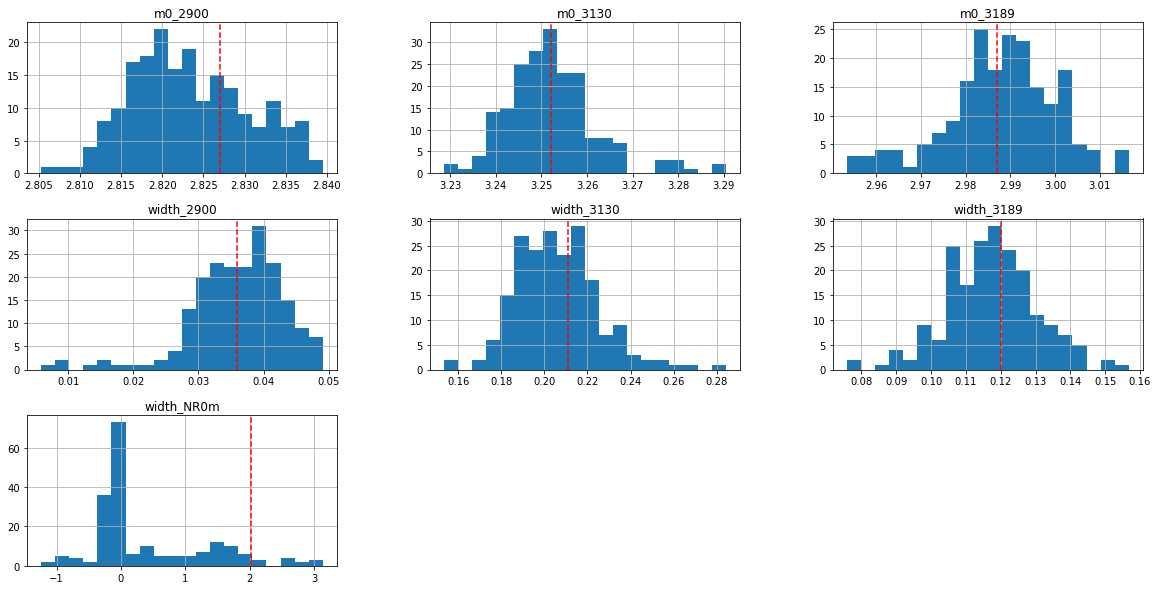

In [12]:
title = ["bootfile","id","m0_2900","m0_3130","m0_3189","width_2900","width_3130","width_3189","width_NR0m"]
df_original = pd.DataFrame(columns=title)
df_original = df_original.append({"bootfile":-999,"id":-999,"m0_2900":-999,"m0_3130":-999,"m0_3189":-999,"width_2900":-999,"width_3130":-999,"width_3189":-999,"width_NR0m":-999},ignore_index=True)
for i in range(0,200):
    temp_id = df_merge[df_merge["mass"]==i]["id"].values[0]
    temp_filename = "funcs_spline/fit-"+str(i)+"-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["bootfile"] = i
    dict_temp["id"] = temp_id
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original = df_original[df_original["bootfile"]>=0]
print(df_original.head())
print(df_original.shape)
df_original.to_csv("fit_result.csv",index=False)
df_result = pd.read_csv("fit_result.csv")
df_result = df_result.drop(["bootfile","id"],axis=1)
#print(df_result.describe())
plots_result = df_result.hist(layout=(3,3),sharex=False,sharey=False,figsize=(20,10),bins=20)
dict_trueValue = {"m0_2900":2.827, "m0_3130":3.252, "m0_3189":2.987, "width_2900":0.036, "width_3130":0.211, "width_3189":0.120, "width_NR0m":2.01}
for i in range(len(plots_result)):
    for ax in plots_result[i]:
        if ax.get_title() == "":
            continue
        ax.axvline(dict_trueValue[ax.get_title()], color="red", linestyle="--")
plt.savefig("parameters.pdf")

### Part 1-3, get fit fractions

In [5]:
def read_reverse_order(file_name):
    """Copied from website. Read a file from the end in a quick way

    Args:
        file_name (_type_): _description_

    Yields:
        _type_: _description_
    """
    # Open file for reading in binary mode
    with open(file_name, 'rb') as read_obj:
        # Move the cursor to the end of the file
        read_obj.seek(0, os.SEEK_END)
        # Get the current position of pointer i.e eof
        pointer_location = read_obj.tell()
        # Create a buffer to keep the last read line
        buffer = bytearray()
        # Loop till pointer reaches the top of the file
        while pointer_location >= 0:
            # Move the file pointer to the location pointed by pointer_location
            read_obj.seek(pointer_location)
            # Shift pointer location by -1
            pointer_location = pointer_location -1
            # read that byte / character
            new_byte = read_obj.read(1)
            # If the read byte is new line character then it means one line is read
            if new_byte == b'\n':
                # Fetch the line from buffer and yield it
                yield buffer.decode()[::-1]
                # Reinitialize the byte array to save next line
                buffer = bytearray()
            else:
                # If last read character is not eol then add it in buffer
                buffer.extend(new_byte)
        # As file is read completely, if there is still data in buffer, then its the first line.
        if len(buffer) > 0:
            # Yield the first line too
            yield buffer.decode()[::-1]

def read_FF(logfile_name):
    """Use function read_reverse_order to read the logfile from the end.
    Because the Fit Fractions is at the end of each log file.

    Args:
        logfile_name (_type_): _description_
    """
    i = 0
    temp_dict = {}
    for line in read_reverse_order(logfile_name):
        if(i>18):
            break
        if(i>5):
            #print({line.split()[0]:line.split()[1]})
            temp_dict[line.split()[0]] = line.split()[1]
            #print(line.split()[1])
            #print(line.split()[0])
        i = i+1
#    temp_dict["bootfile"] = logfile_name
    return temp_dict

In [6]:
df_FF = pd.DataFrame(read_FF("test.log"),index=[0])
df_original = pd.read_csv("fit_result.csv")
df_original = df_original[["bootfile","id"]]
arr_original = df_original.values.tolist()
for i in range(len(arr_original)):
    temp_filename = "log_bootstrappSpline/fit-"+str(arr_original[i][0])+"-"+str(arr_original[i][1]).zfill(4)+".log"
    df_FF = df_FF.append(read_FF(temp_filename),ignore_index=True)
df_FF = df_FF.drop([0])
print(df_FF.head())
print(df_FF.shape)
df_FF.to_csv("FF_result.csv",index=False)
df_FF_new = pd.read_csv("FF_result.csv") # export to csv and read it again can show the correct df.describe() result. so ridiculous.
df_FF_new.describe()

    Total Y_L_2765 Y_L_3189 Y_L_3130 Y_L_2900 Y_L_2880 Y_L_2860 Y_L_2940  \
1  116.53     2.80    14.42    12.65     4.53     0.41     5.90     0.30   
2  121.39     4.08    20.28    12.73     4.94     0.65     3.92     0.71   
3  116.78     4.50    16.08    12.80     5.67     0.63     2.57     0.39   
4  120.48     3.31    12.87    13.49     6.08     0.55     4.21     0.55   
5   99.93     3.65     5.92     9.93     1.88     0.15     7.02     1.17   

  X_f2_1950 X_rho_2150 X_f2_2150 X_Fwave X_NR0m  
1      3.80       8.67      5.42   57.51   0.12  
2      3.96       8.39      6.00   53.45   2.30  
3      4.07       7.61      5.33   54.81   2.30  
4      5.32      14.37      9.12   44.45   6.15  
5      2.97      10.04      6.02   47.70   3.47  
(200, 13)


Total    Y_L_2765    Y_L_3189    Y_L_3130    Y_L_2900    Y_L_2880  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean   113.083450    4.672900   13.644800   11.737800    4.877250    0.348300   
std      7.889834    1.039295    3.659432    1.362822    1.627208    0.160358   
min     94.820000    2.290000    3.900000    8.300000    0.760000    0.050000   
25%    106.760000    3.905000   11.490000   10.700000    3.797500    0.230000   
50%    113.225000    4.600000   13.860000   11.670000    4.765000    0.320000   
75%    120.012500    5.335000   16.372500   12.682500    5.990000    0.442500   
max    125.500000    8.720000   22.420000   15.600000   10.160000    0.780000   

         Y_L_2860    Y_L_2940   X_f2_1950  X_rho_2150   X_f2_2150     X_Fwave  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     3.938200    0.374150    3.937250    8.948250    5.471300   51.181400   
std      1.220095    0.305091    1.050539    1.648123    1.023265    6.458683   
min      2.140000    0.010000    2.090000    5.950000    2.910000   33.250000   
25%      3.085000    0.150000    3.197500    7.785000    4.857500   47.850000   
50%      3.690000    0.280000    3.850000    8.725000    5.495000   51.645000   
75%      4.390000    0.522500    4.482500    9.675000    5.977500   55.665000   
max      9.130000    1.650000   10.330000   15.070000   11.050000   63.100000   

           X_NR0m  
count  200.000000  
mean     3.951150  
std      3.496273  
min      0.070000  
25%      1.737500  
50%      2.975000  
75%      4.852500  
max     17.900000

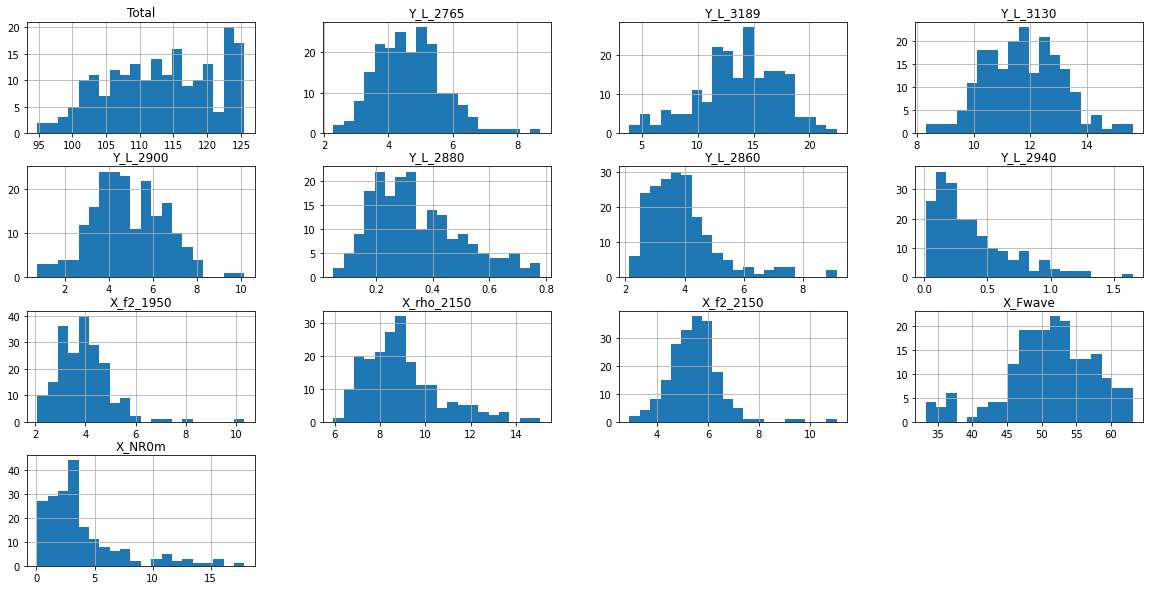

In [7]:
df_FF_new.hist(layout=(4,4),sharex=False,sharey=False,figsize=(20,10),bins=20)
plt.savefig("FitFraction.pdf")

## Part 2, calculate the asymmetrical error for fit fraction and parameters

In [8]:
def cal_asym_std(df_input, mean_input):
    if df_input.empty:
        return -999
    else:
        return sqrt(pow(df_input - mean_input,2).sum()/df_input.size)

def read_logfile(logfile):
    one_log = make_dataclass("one_log", [("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[1].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [9]:
df_FF = pd.read_csv("FF_result.csv")
df_FF.describe()

#dict_FF_model0 = {"X_f2_2150":5.12, "X_rho_2150":9.36, "X_f2_1950":3.63, "X_NR0m":2.41, "X_Fwave":49.77, "Y_L_2765":8.51, "Y_L_2940":0.14, "Y_L_2860":4.07, "Y_L_2880":0.28, "Y_L_2900":4.22, "Y_L_3130":12.26, "Y_L_3189":13.40}
dict_FF_model0 = {"X_f2_2150":5.10, "X_rho_2150":9.21, "X_f2_1950":3.69, "X_NR0m":2.52, "X_Fwave":49.66, "Y_L_2765":3.94, "Y_L_2940":0.14, "Y_L_2860":4.12, "Y_L_2880":0.28, "Y_L_2900":4.23, "Y_L_3130":12.25, "Y_L_3189":13.41}

temp_name = "X_f2_2150"
df_FF_temp = df_FF[df_FF[temp_name] > dict_FF_model0[temp_name]]

list_up = []
list_lo = []
for key,value in dict_FF_model0.items():
    df_FF_up = df_FF[ df_FF[key] > value ][key]
    df_FF_lo = df_FF[ df_FF[key] < value ][key]
    list_up.append(cal_asym_std(df_FF_up, value))
    list_lo.append(cal_asym_std(df_FF_lo, value))

i=0
for key,value in dict_FF_model0.items():
    temp_FF = "$" + "{:.2f}".format(value) + "^{+" + "{:.2f}".format(list_up[i]) +"}" + "_{-" + "{:.2f}".format(list_lo[i]) +"}$ "
    line = "{:<15} & {:<30} \\\\".format(key, temp_FF)
    print(line)
    i = i+1

X_f2_2150       & $5.10^{+1.22}_{-0.79}$         \\
X_rho_2150      & $9.21^{+2.08}_{-1.42}$         \\
X_f2_1950       & $3.69^{+1.27}_{-0.74}$         \\
X_NR0m          & $2.52^{+4.68}_{-1.39}$         \\
X_Fwave         & $49.66^{+6.48}_{-6.85}$        \\
Y_L_2765        & $3.94^{+1.43}_{-0.61}$         \\
Y_L_2940        & $0.14^{+0.44}_{-0.07}$         \\
Y_L_2860        & $4.12^{+1.63}_{-0.97}$         \\
Y_L_2880        & $0.28^{+0.21}_{-0.10}$         \\
Y_L_2900        & $4.23^{+1.98}_{-1.28}$         \\
Y_L_3130        & $12.25^{+1.18}_{-1.60}$        \\
Y_L_3189        & $13.41^{+3.63}_{-3.69}$        \\


In [10]:
dict_FitParameters_model0 = {"m0_2900":2.827,"m0_3130":3.252,"m0_3189":2.988,"width_2900":0.036,"width_3130":0.211,"width_3189":0.121}
list_up_FP = []
list_lo_FP = []
for key,value in dict_FitParameters_model0.items():
    df_result_up = df_result[ df_result[key] > value ][key]
    df_result_lo = df_result[ df_result[key] < value ][key]
    list_up_FP.append(cal_asym_std(df_result_up, value))
    list_lo_FP.append(cal_asym_std(df_result_lo, value))
i=0
for key,value in dict_FitParameters_model0.items():
    temp_FF = "$" + str(value) + "^{+" + "{:.3f}".format(list_up_FP[i]) +"}" + "_{-" + "{:.3f}".format(list_lo_FP[i]) +"}$ "
    line = "{:<15} & {:<30} &".format(key, temp_FF)
    print(line)
    i = i+1

m0_2900         & $2.827^{+0.006}_{-0.009}$      &
m0_3130         & $3.252^{+0.011}_{-0.008}$      &
m0_3189         & $2.988^{+0.011}_{-0.013}$      &
width_2900      & $0.036^{+0.006}_{-0.008}$      &
width_3130      & $0.211^{+0.020}_{-0.020}$      &
width_3189      & $0.121^{+0.012}_{-0.015}$      &


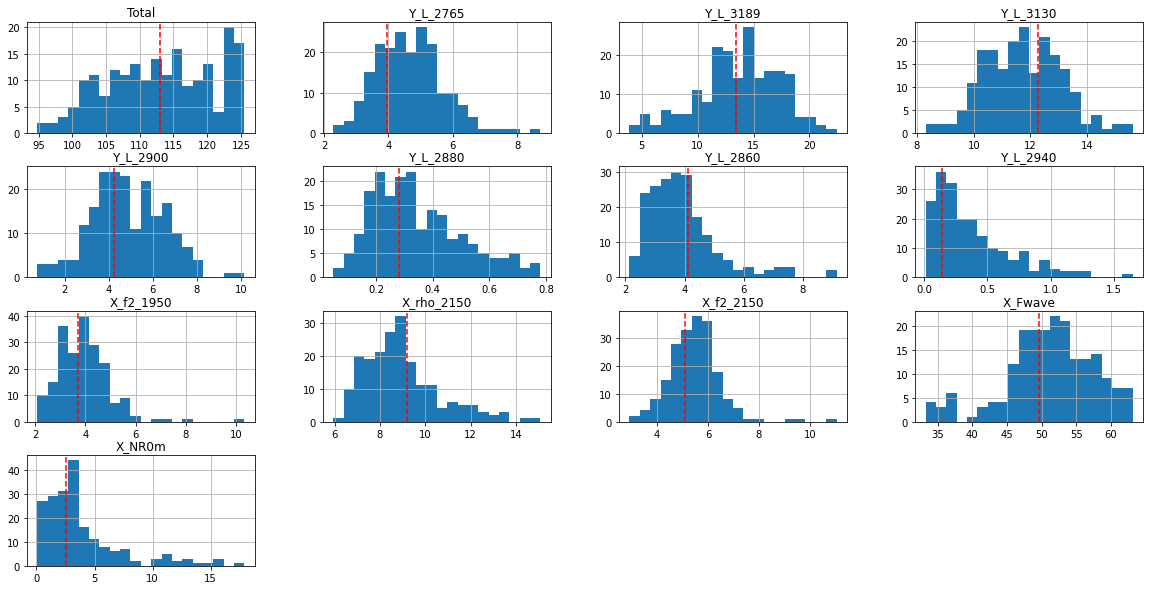

In [11]:
plots_FF=df_FF_new.hist(layout=(4,4),sharex=False,sharey=False,figsize=(20,10),bins=20)
for i in range(len(plots_FF)):
    for ax in plots_FF[i]:
        if ax.get_title() == "Total":
            temp_mean = 113
        elif ax.get_title() == "":
            continue
        else:
            temp_mean = dict_FF_model0[ax.get_title()]
        ax.axvline(x=temp_mean,color="red",linestyle="--")

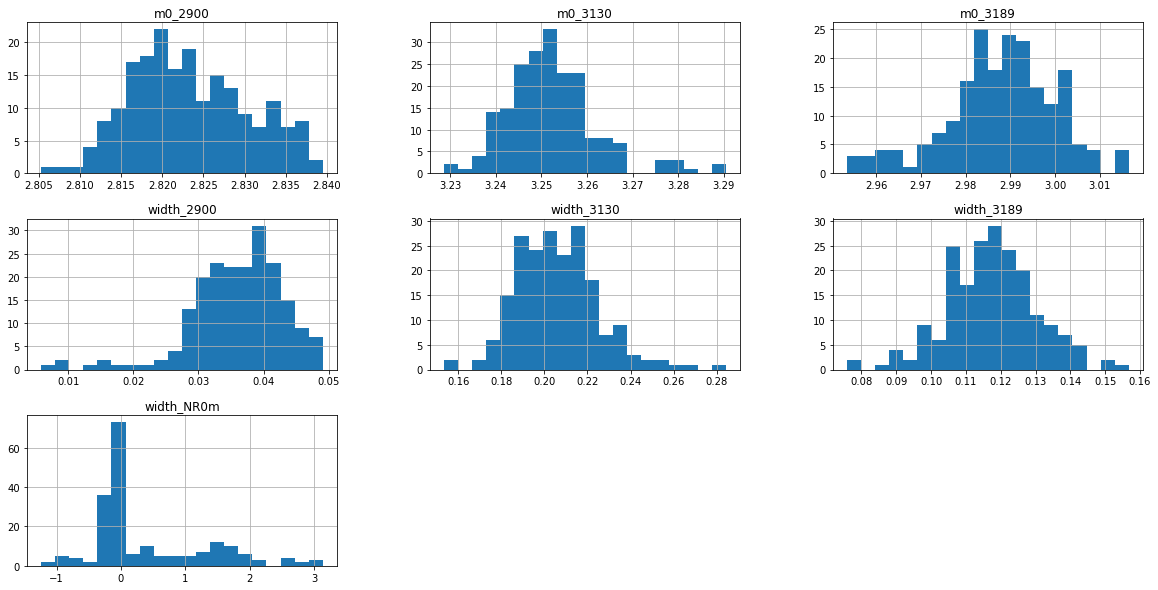

In [18]:
#Merge two plots into one
df1 = read_logscan("/disk401/lhcb/qinning/b2dpp_farm10/qnFit/bootstrapping/check_logBootstrappSpline.txt")
df_converged = df1[df1["status"] == "CONVERGED"]
df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
title = ["bootfile","id","m0_2900","m0_3130","m0_3189","width_2900","width_3130","width_3189","width_NR0m"]
df_original = pd.DataFrame(columns=title)
df_original = df_original.append({"bootfile":-999,"id":-999,"m0_2900":-999,"m0_3130":-999,"m0_3189":-999,"width_2900":-999,"width_3130":-999,"width_3189":-999,"width_NR0m":-999},ignore_index=True)
for i in range(0,200):
    temp_id = df_merge[df_merge["mass"]==i]["id"].values[0]
    temp_filename = "funcs_spline/fit-"+str(i)+"-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["bootfile"] = i
    dict_temp["id"] = temp_id
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original = df_original[df_original["bootfile"]>=0]
df_original.to_csv("fit_result.csv",index=False)
df_result = pd.read_csv("fit_result.csv")
df_result = df_result.drop(["bootfile","id"],axis=1)
#print(df_result.describe())
plots_result = df_result.hist(layout=(3,3),sharex=False,sharey=False,figsize=(20,10),bins=20)
#dict_trueValue = {"m0_2900":2.827, "m0_3130":3.252, "m0_3189":2.987, "width_2900":0.036, "width_3130":0.211, "width_3189":0.120, "width_NR0m":2.01}
#for i in range(len(plots_result)):
#    for ax in plots_result[i]:
#        if ax.get_title() == "":
#            continue
#        ax.axvline(dict_trueValue[ax.get_title()], color="red", linestyle="--")

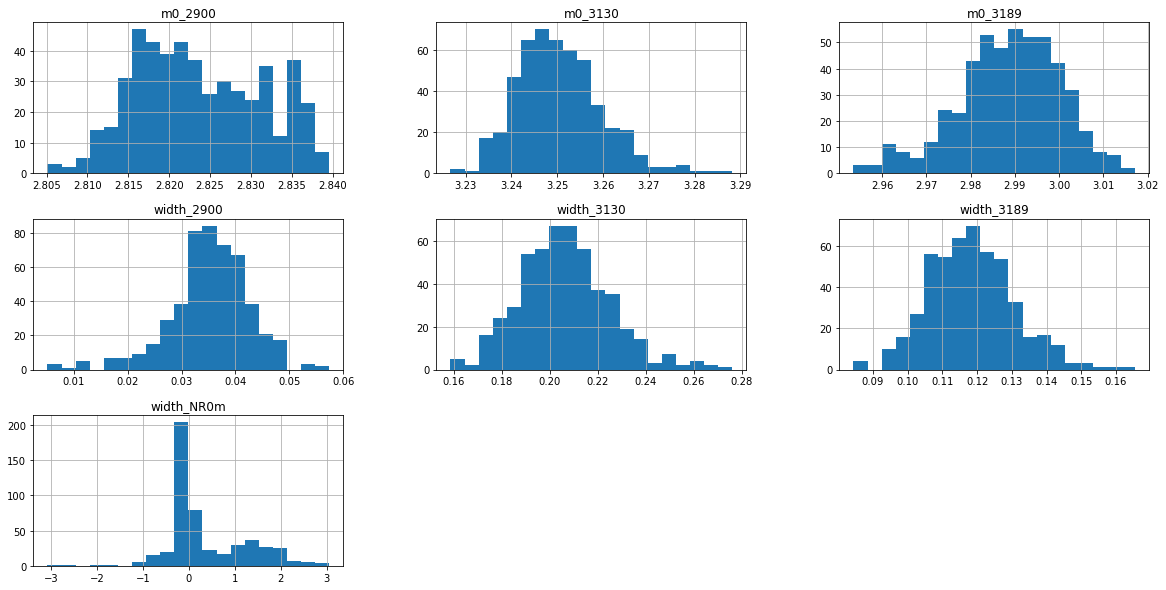

In [17]:
#Merge two plots into one
df1 = read_logscan("/disk401/lhcb/qinning/b2dpp_farm10/qnFit/bootstrapping/check_log.txt")
df_converged = df1[df1["status"] == "CONVERGED"]
df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
title = ["bootfile","id","m0_2900","m0_3130","m0_3189","width_2900","width_3130","width_3189","width_NR0m"]
df_original = pd.DataFrame(columns=title)
df_original = df_original.append({"bootfile":-999,"id":-999,"m0_2900":-999,"m0_3130":-999,"m0_3189":-999,"width_2900":-999,"width_3130":-999,"width_3189":-999,"width_NR0m":-999},ignore_index=True)
for i in range(0,500):
    temp_id = df_merge[df_merge["mass"]==i]["id"].values[0]
    temp_filename = "funcs/fit-"+str(i)+"-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["bootfile"] = i
    dict_temp["id"] = temp_id
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original = df_original[df_original["bootfile"]>=0]
df_original.to_csv("fit_result.csv",index=False)
df_result = pd.read_csv("fit_result.csv")
df_result = df_result.drop(["bootfile","id"],axis=1)
plots_result2 = df_result.hist(layout=(3,3),sharex=False,sharey=False,figsize=(20,10),bins=20)